In [1]:
import pandas as pd
import random
import simpy

## Poisson Processes and Exponential Distributions

Suppose we told that certain events, for example the arrival of customer orders from a web page, occur at an average rate of $\lambda$ events per unit time. We assume these events are independent from one another, and the process behaves uniformly over time. How can this be modeled for the purpose of simulation? 

This is known as a **Poisson process**, one of the most widely studied and useful constructs in statistics and probability theory. Here are a few key facts about Poisson processes:

1. Given a average rate of events $\lambda$ per unit time, the probability of $n$ events occuring in a period $\tau$ is given by the [Poisson distribution](https://en.wikipedia.org/wiki/Poisson_distribution) \begin{align}\\ P(n;\lambda\tau) & = \frac{(\lambda\tau)^n e^{-\lambda\tau}}{n!}\\ & \end{align} This probability distribution has a mean $\lambda\tau$ and a standard deviation $\sqrt{\lambda\tau}$.

2. The time between events is given by the Exponential distribution with probability density function 
\begin{align}\\ f^{Exp}_\lambda(t) & = \lambda e^{-\lambda t}\\ & \end{align} This distribution has a mean $\frac{1}{\lambda}$ and a standard deviation $\frac{1}{\lambda}$.

Knowing the statistical distribution of time between events provides a convenient way to simulate the behavior of Poisson process. Given a average rate $\lambda$ of events per unit time, the technique is to draw random variables from an exponential distribution, then to wait that period of time before issuing another event.

### Example: Simulate Customers Arriving at a Known Rate

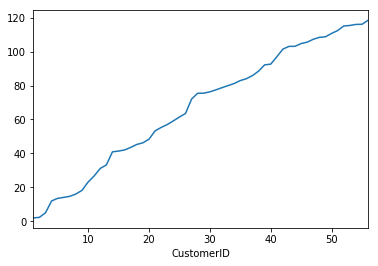

In [103]:
%matplotlib inline
import matplotlib.pyplot as plt
import random
import simpy
import pandas as pd

rate = 1/2  # customers per minute

env = simpy.Environment()
log = []

def customer_arrival(env,rate):
    n = 1
    while True:
        yield env.timeout(random.expovariate(rate))
        log.append([n, env.now, 'Arrival'])
        n += 1
        
env.process(customer_arrival(env,rate))
env.run(120)

# process log

df = pd.DataFrame(log, columns = ['CustomerID','Time','Event'])
df = df.set_index('CustomerID')
df.head()

df['Time'].plot(kind='line')

## Let's add a Customer Queue

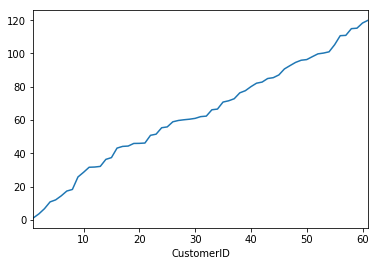

In [104]:
%matplotlib inline
import matplotlib.pyplot as plt
import random
import simpy
import pandas as pd

rate = 1/2  # customers per minute

env = simpy.Environment()
customer_queue = simpy.Store(env)

log = []

def customer_arrival(env,rate):
    n = 1
    while True:
        yield env.timeout(random.expovariate(rate))
        yield customer_queue.put(n)
        log.append([n, env.now, 'Arrival'])
        n += 1
        
env.process(customer_arrival(env,rate))
env.run(120)

# process log

df = pd.DataFrame(log, columns = ['CustomerID','Time','Event'])
df = df.set_index('CustomerID')
df.head()

df['Time'].plot(kind='line')

## Let's Provide Some Service to the Customers

Our customers are just hanging around, waiting in line.  Let's provide some service by taking the customer's order.  We'll call this the 'service_time' which actually consists of two parts, order taking and order fulfillment.

Average time experienced by a customer =  4.248690064006545


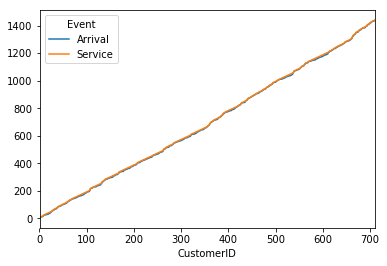

In [314]:
%matplotlib inline
import matplotlib.pyplot as plt
import random
import simpy
import pandas as pd

rate = 1/2            # customers per minute
service_time = 1.6    # service time

env = simpy.Environment()
customer_queue = simpy.Store(env)

log = []

def customer_arrival(env,rate):
    n = 1
    while True:
        yield env.timeout(random.expovariate(rate))
        yield customer_queue.put(n)
        log.append([n, env.now, 'Arrival'])
        n += 1
        
def customer_service(env):
    while True:
        n = yield customer_queue.get()
        yield env.timeout(service_time)
        log.append([n, env.now, 'Service'])
        
env.process(customer_arrival(env,rate))
env.process(customer_service(env))
env.run(1440)

# process log

df = pd.DataFrame(log, columns = ['CustomerID','Time','Event'])
df = df.set_index('CustomerID')
df = df.pivot(columns='Event',values='Time')
df.head()

df.plot(kind='line')

print('Average time experienced by a customer = ',(df['Service']-df['Arrival']).mean())

## Little's Law

Provided service time is less than 1/rate, the average time the customer experiences appears to remain bounded. The average time experience by the customer grows as the service_time approaches 1/rate, then becomes unstable in time when service time is greater than 1/rate. In a nutshell, we need

$$\tau_{service} < \frac{1}{\lambda}$$

for stability.

But what about the number of customers in process? Is there anything we can say about how many customers waiting and in the process of being served?

Average time experienced by a customer =  21.55
Average queue length = 9.90354517726
Average number of customers in process = 10.9


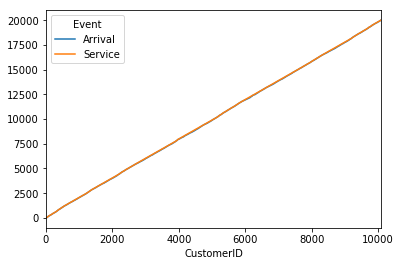

In [272]:
%matplotlib inline
import matplotlib.pyplot as plt
import random
import simpy
import pandas as pd

rate = 1/2            # customers per minute
service_time = 1.9    # service time

env = simpy.Environment()
customer_queue = simpy.Store(env)

log = []

def customer_arrival(env,rate):
    n = 1
    while True:
        yield env.timeout(random.expovariate(rate))
        yield customer_queue.put(n)
        log.append([n, env.now, 'Arrival'])
        n += 1
        
def customer_service(env):
    while True:
        n = yield customer_queue.get()
        yield env.timeout(service_time)
        log.append([n, env.now, 'Service'])

rlog = []
def reporter(env):
    while True:
        yield env.timeout(1)
        rlog.append([len(customer_queue.items)])
        
env.process(customer_arrival(env,rate))
env.process(customer_service(env))
env.process(reporter(env))
env.run(20000)

# process log

df = pd.DataFrame(log, columns = ['CustomerID','Time','Event'])
df = df.set_index('CustomerID')
df = df.pivot(columns='Event',values='Time')
df.head()

df.plot(kind='line')

print('Average time experienced by a customer = ',round((df['Service']-df['Arrival']).mean(),2))
print('Average queue length =', np.mean(rlog))
print('Average number of customers in process =', round(1 + np.mean(rlog),2))

What we observe, empirically, is [Little's Law](https://en.wikipedia.org/wiki/Little%27s_law) an important law of queueing systems. Let's call $W$ the average time a customer spends in the system (included both wait time and service time), and $\lambda$ the average rate of arrival. 

If the system is at steady state, than average arrival rate must be equal to the average departure rate. Under this condition, the average number of customers in the system is

$$L = \lambda W$$

This apparently simple result took is one of the foundations of Operations Research, and wasn't proved mathematically until 1961.

Chemical Engineers would call $W$ 'residence time'.

The implications of Little's law are profound, including things like the design and operation of customer service facilities, warehousing, inventory management, and lean manufacturing.



## Lognormal Distributions of Service Time

### Normal Distributions

A Normal distribution (also commonly called a Gaussian distribution) is usually the first (and too frequently the only) example of a statistical distribution encountered by engineering students. It is the common 'bell-shaped' curve described by the equation

$$ f^N_{\mu_X,\sigma_X}(x) = \frac{1}{\sqrt{2\pi\sigma_X^2}}e^{-\frac{(x-\mu_X)^2}{2\sigma_X^2}} $$

where $\mu_X$ is the mean and $\sigma_X$ is the standard deviation for the random variable $X$.  It has a lot of favoriable properities and is often a good starting point for the description of random phenomena.

Is it useful for modeling service times?

Let's look at a typical plot of the probability density function

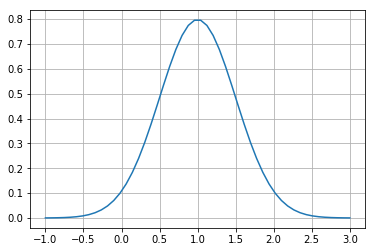

In [191]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

mu = 1
sigma = 0.5

x = np.linspace(mu-4*sigma,mu+4**sigma)
f_x = (1/np.sqrt(2*np.pi*sigma**2))*np.exp(-(x - mu)**2/2/sigma**2)

plt.plot(x,f_x)
plt.grid()

You already know how to fit a Normal distribution to data. Given a set of experimental values $x_1, x_2, \ldots, x_N$, the most commonly used estimates of $\mu_x$ is 

$$\hat{\mu}_X = \bar{x} =  \frac{1}{N} \sum_{k=1}^N x_k$$

and of $\sigma_x$ is 

$$\hat{\sigma}_X = s_X = \sqrt{\frac{1}{N-1}\sum_{k=1}^N (x_k - \bar{x})}$$

This all familiar and easy enought. But we can immediately see a problem using this as a model of service time. This distribution would allow for negative service times, which doesn't make physical sense.

### Lognormal Distribution

Suppose to have measurements of service times $t_1, t_2, \ldots, t_N$. By their nature, these times are all non-negative numbers. We take logarithms

$$x_k = \ln(t_k)$$

and find the logarithms have mean $\mu_X$ and standard deviation $\sigma_X$. What can we say about the distribution of service times?

Under these conditions, the service time distribution is **Lognormal**. The distribution is given by

$$f^{LN}_{\mu_X, \sigma_X}(t) = \frac{1}{t\sqrt{2\pi\sigma_X^2}} e^{-\frac{(\ln(t)-\mu_X)^2}{2\sigma_X^2}}$$

At this point we are faced wiht a problem.  The lognormal distribution is parameterized in terms of an underlying normal distribution.  How to we estimate those parameters directly in terms of the observations $t_1, t_2, \ldots, t_N$.

There are some simple formulae for this purpose.  Let $m$ be the mean of the observed service times, and let $\nu$ be the standard deviation. Then

$$\mu = \ln\left(\frac{m}{\sqrt{1 + \frac{\nu^2}{m^2}}}\right)$$

and

$$\sigma = \sqrt{\ln\left(1 +\frac{\nu^2}{m^2}\right)}$$

For example, suppose we observe a median service time of 2 minutes, and a standard deviation of 1 minutes. Then



mu =  0.973449145714 sigma = 0.500326179515
3.00725818338 1.62442122452


(0, 8)

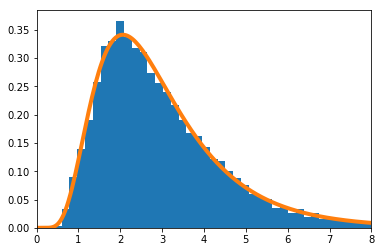

In [280]:
import numpy as np
import random

# mean and standard deviation of observed service times
# that appear to be lognormal distribution
m = 3
nu = 1.6

# mean and standard deviation of underlying normal distribution
mu = np.log(m/np.sqrt(1 + nu**2/m**2))
sigma = np.sqrt(np.log(1+nu**2/m**2))

print('mu = ', mu, 'sigma =', sigma)

# generate random variates from a lognormal distribution
t = [random.lognormvariate(mu,sigma) for k in range(0,10000)]
plt.hist(t,bins=100,normed=True)
print(np.mean(t),np.std(t))

# compare distributions
tp = np.linspace(0.001,12,300)
fLN = 1/(tp*sigma*np.sqrt(2*np.pi)) * np.exp(-(np.log(tp) - mu)**2/2/sigma**2)
plt.plot(tp,fLN,lw=4)
plt.xlim(0,8)


## Random Service Time

Average time experienced by a customer =  4.67
Average queue length = 1.48922863099
Average number of customers in process = 2.49


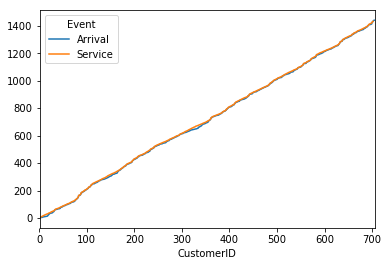

In [283]:
%matplotlib inline
import matplotlib.pyplot as plt
import random
import simpy
import pandas as pd

rate = 0.5  # customers per minute

# random service time
mean_service_time = 1.6
std_service_time = 0.5
def random_service_time(m,nu):
    mu = np.log(m/np.sqrt(1 + nu**2/m**2))
    sigma = np.sqrt(np.log(1+nu**2/m**2))
    return random.lognormvariate(mu,sigma)

env = simpy.Environment()
customer_queue = simpy.Store(env)

log = []

def customer_arrival(env,rate):
    n = 1
    while True:
        yield env.timeout(random.expovariate(rate))
        yield customer_queue.put(n)
        log.append([n, env.now, 'Arrival'])
        n += 1
        
def customer_service(env):
    while True:
        n = yield customer_queue.get()
        yield env.timeout(random_service_time(mean_service_time,std_service_time))
        log.append([n, env.now, 'Service'])
        
rlog = []
def reporter(env):
    while True:
        yield env.timeout(1)
        rlog.append([len(customer_queue.items)])

        
env.process(customer_arrival(env,rate))
env.process(customer_service(env))
env.process(reporter(env))
env.run(1440)

# process log

df = pd.DataFrame(log, columns = ['CustomerID','Time','Event'])
df = df.set_index('CustomerID')
df = df.pivot(columns='Event',values='Time')
df.head()

df.plot(kind='line')

print('Average time experienced by a customer = ',round((df['Service']-df['Arrival']).mean(),2))
print('Average queue length =', np.mean(rlog))
print('Average number of customers in process =', round(1 + np.mean(rlog),2))

## Let's add multiple Queues

Average time experienced by a customer =  3.99
Average queue length = 0.952050034746
Average number of customers in process = 1.95


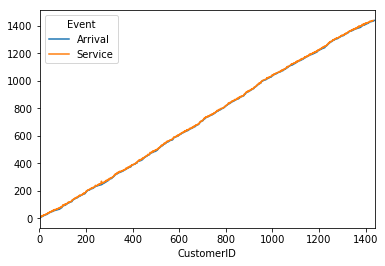

In [286]:
%matplotlib inline
import matplotlib.pyplot as plt
import random
import simpy
import pandas as pd

rate = 1.0  # customers per minute

# random service time
mean_service_time = 3.0
std_service_time = 1.6
def random_service_time(m,nu):
    mu = np.log(m/np.sqrt(1 + nu**2/m**2))
    sigma = np.sqrt(np.log(1+nu**2/m**2))
    return random.lognormvariate(mu,sigma)

env = simpy.Environment()
customer_queue = simpy.Store(env)

log = []

def customer_arrival(env,rate):
    n = 1
    while True:
        yield env.timeout(random.expovariate(rate))
        yield customer_queue.put(n)
        log.append([n, env.now, 'Arrival'])
        n += 1
        
def customer_service(env):
    while True:
        n = yield customer_queue.get()
        yield env.timeout(random_service_time(mean_service_time,std_service_time))
        log.append([n, env.now, 'Service'])
        
rlog = []
def reporter(env):
    while True:
        yield env.timeout(1)
        rlog.append([len(customer_queue.items)])

        
env.process(customer_arrival(env,rate))
env.process(customer_service(env))
env.process(customer_service(env))
env.process(customer_service(env))
env.process(customer_service(env))
env.process(reporter(env))
env.run(1440)

# process log

df = pd.DataFrame(log, columns = ['CustomerID','Time','Event'])
df = df.set_index('CustomerID')
df = df.pivot(columns='Event',values='Time')
df.head()

df.plot(kind='line')

print('Average time experienced by a customer = ',round((df['Service']-df['Arrival']).mean(),2))
print('Average queue length =', np.mean(rlog))
print('Average number of customers in process =', round(1 + np.mean(rlog),2))

Average time experienced by a customer =  504.12
Average queue length = 505.311327311
Average number of customers in process = 506.31


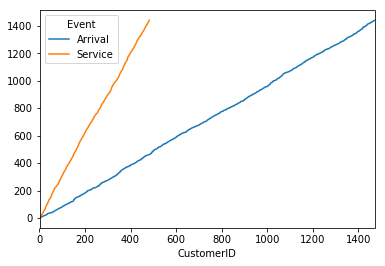

In [312]:
%matplotlib inline
import matplotlib.pyplot as plt
import random
import simpy
import pandas as pd

rate = 1.0  # customers per minute

# random service time
mean_service_time = 3.0
std_service_time = 1.6
def random_service_time(m,nu):
    mu = np.log(m/np.sqrt(1 + nu**2/m**2))
    sigma = np.sqrt(np.log(1+nu**2/m**2))
    return random.lognormvariate(mu,sigma)

env = simpy.Environment()
customer_queue = simpy.Store(env)
agents = simpy.Resource(env,20)

log = []

def customer_arrival(env,rate):
    n = 1
    while True:
        yield env.timeout(random.expovariate(rate))
        yield customer_queue.put(n)
        log.append([n, env.now, 'Arrival'])
        n += 1
        
def customer_service(env):
    while True:
        with agents.request() as req:
            yield req
            n = yield customer_queue.get()
            yield env.timeout(random_service_time(mean_service_time,std_service_time))
            log.append([n, env.now, 'Service'])
        
rlog = []
def reporter(env):
    while True:
        yield env.timeout(1)
        rlog.append([len(customer_queue.items)])

env.process(customer_arrival(env,rate))
env.process(customer_service(env))
env.process(reporter(env))
env.run(1440)

# process log

df = pd.DataFrame(log, columns = ['CustomerID','Time','Event'])
df = df.set_index('CustomerID')
df = df.pivot(columns='Event',values='Time')
df.head()

df.plot(kind='line')

print('Average time experienced by a customer = ',round((df['Service']-df['Arrival']).mean(),2))
print('Average queue length =', np.mean(rlog))
print('Average number of customers in process =', round(1 + np.mean(rlog),2))

In [313]:
df

Event,Arrival,Service
CustomerID,,
1,1.392429,4.283694
2,2.301943,7.236877
3,2.463589,8.699290
4,3.332272,10.551101
5,3.462661,12.618823
6,5.833542,15.788200
7,5.948926,17.264692
8,6.521799,22.703768
9,7.777720,24.365614
